In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import colorsys


from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


randomState = 42
rng = np.random.RandomState(randomState)

# Create an Artificial Dataset

In [2]:
rng = np.random.RandomState(randomState)
X, y = make_classification(n_samples=1200, n_features=100, n_informative=20, n_redundant=60, n_repeated=5, n_classes=2, n_clusters_per_class=3, flip_y=0.02, class_sep=1., shift=1.0, scale=3.0, random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33333, random_state=rng)
classes = np.unique(y)
print(classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

[0 1]
(800, 100) (800,) (400, 100) (400,)


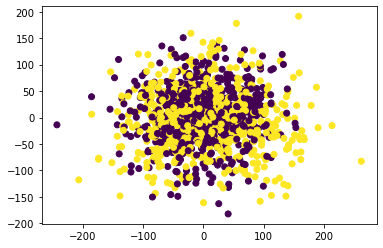

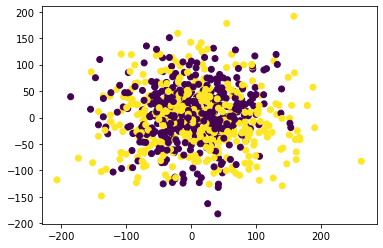

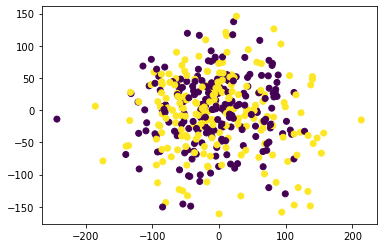

In [3]:
pca = PCA(n_components=2, svd_solver='full')
X2d = pca.fit_transform(X)
plt.scatter(X2d[:,0],X2d[:,1], c=y)
plt.show()
X2d_train = pca.transform(X_train)
plt.scatter(X2d_train[:,0],X2d_train[:,1], c=y_train)
plt.show()
X2d_test = pca.transform(X_test)
plt.scatter(X2d_test[:,0],X2d_test[:,1], c=y_test)
plt.show()

The data looks sufficiently complicated in 2D to make me believe that it is not too simple to be learned with few datapoints. Thus, it should allow us to test averaging vs. daisy-chaining on MLPs with it. First, we need to verify, though, that an MLP can properly learn this data.

# Check an MLP on the Data

In [26]:
def getACC(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

def getACC_getColor(model, X, y):
    y_pred = model.predict(X)
    colors = []
    for i in range(len(y_test)):
        c = 'b'
        if y_train[i] == 0 and y_pred[i] == 0:
            c = 'darkgreen'
        elif y_train[i] == 1 and y_pred[i] == 1:
            c = 'lime'
        else:
            c = 'red'
        colors.append(c)
    return accuracy_score(y, y_pred), colors

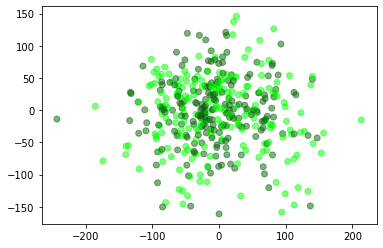

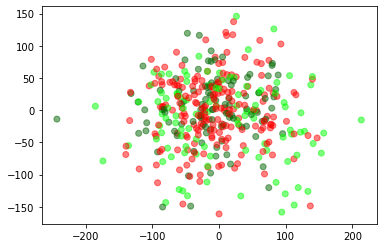

Train ACC:  1.0  Test ACC:  0.875


In [27]:
rng = np.random.RandomState(randomState)
mlp = MLPClassifier(hidden_layer_sizes=(100,50,20), activation='relu', alpha=0.0001)
#sgd_iter.fit(X_train,y_train)
for i in range(100):
    mlp.partial_fit(X_train,y_train, classes = classes)

#check train performance
train_ACC,colors = getACC_getColor(mlp, X_train, y_train)

plt.scatter(X2d_test[:,0],X2d_test[:,1], c=colors, alpha=0.5)
plt.show()

#check test performance   
test_ACC,colors = getACC_getColor(mlp, X_test, y_test)
plt.scatter(X2d_test[:,0],X2d_test[:,1], c=colors, alpha=0.5)
plt.show()

print("Train ACC: ",train_ACC," Test ACC: ", test_ACC)

# Implementing Averaging and DaisyChaining

In [13]:
def splitIntoLocalData(X_train, y_train, m, n_local, rng):
    n = y_train.shape[0]
    if m*n_local > n:
        print("Error: not enough data (n=",n,") for",m,"sets of size ",n_local,". Reducing local size to",n//m,".")
        n_local = n // m
        
    idxs = np.arange(n)
    rng.shuffle(idxs)
    bucket_size = n_local
    i = 0
    Xs, Ys = [],[]
    while (i+1)*bucket_size <= n and i < m:
        idx = idxs[i*bucket_size:(i+1)*bucket_size]
        Xs.append(X_train[idx,:])
        Ys.append(y_train[idx])
        i += 1
    return Xs, Ys    

In [15]:
def averageMLPs(models):
    m = len(models)
    layers = len(models[0].coefs_)
    for l in range(layers):
        avgCoef = np.zeros(models[0].coefs_[l].shape)
        avgIntercept = np.zeros(models[0].intercepts_[l].shape)
        for model in models:
            avgCoef += model.coefs_[l].copy()
            avgIntercept += model.intercepts_[l].copy()
        avgCoef /= float(m)
        avgIntercept /= float(m)
        for model in models:
            model.coefs_[l] = avgCoef.copy()
            model.intercepts_[l] = avgIntercept.copy()
            if hasattr(model, '_optimizer'): #the MLP implementation only passes its weights to the optimizer once...
                params = model.coefs_ + model.intercepts_
                model._optimizer.params = [param for param in params]
    return models
        
def simpleDaisyChain(models, perm):
    models = models[perm]
    return models

def runAveraging(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=1, classes = None):
    trainACCs, testACCs = [], []
    m = len(localModels)
    if classes is None:
        classes = np.unique(y_test)
    trainACCs, testACCs = [],[]
    for r in range(rounds):
        for i in range(m):
            localModels[i].partial_fit(local_Xtrains[i], local_ytrains[i], classes = classes)
        if (r+1) % b == 0: #we don't want to average in the first round...
            localModels = averageMLPs(localModels)
        trainACCs.append([])
        testACCs.append([])
        for i in range(m):
            trainACCs[-1].append(getACC(localModels[i], local_Xtrains[i], local_ytrains[i]))
            testACCs[-1].append(getACC(localModels[i], X_test, y_test))
    #final model
    avgModel = averageMLPs(localModels)[0]
    for i in range(m):
        trainACCs[-1].append(getACC(avgModel, local_Xtrains[i], local_ytrains[i]))
        testACCs[-1].append(getACC(avgModel, X_test, y_test))
    return avgModel, trainACCs, testACCs

def runSimpleDaisyChaining(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=1, classes = None, fix_permutation=False):
    trainACCs, testACCs = [], []
    m = len(localModels)
    if classes is None:
        classes = np.unique(y_test)
    trainACCs, testACCs = [],[]
    perm = np.arange(m)
    rng.shuffle(perm)
    for r in range(rounds):
        for i in range(m):
            localModels[i].partial_fit(local_Xtrains[i], local_ytrains[i], classes = classes)
        if r % b == 0:
            if not fix_permutation:
                rng.shuffle(perm)
            localModels = simpleDaisyChain(localModels, perm)
        trainACCs.append([])
        testACCs.append([])
        for i in range(m):
            trainACCs[-1].append(getACC(localModels[i], local_Xtrains[i], local_ytrains[i]))
            testACCs[-1].append(getACC(localModels[i], X_test, y_test))
    #final model
    avgModel = averageMLPs(localModels)[0]
    for i in range(m):
        trainACCs[-1].append(getACC(avgModel, local_Xtrains[i], local_ytrains[i]))
        testACCs[-1].append(getACC(avgModel, X_test, y_test))
    return avgModel, trainACCs, testACCs

def runAverageAndDaisyChaining(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=1, bavg = 2, classes = None, fix_permutation=False):
    trainACCs, testACCs = [], []
    m = len(localModels)
    if classes is None:
        classes = np.unique(y_test)
    trainACCs, testACCs = [],[]
    perm = np.arange(m)
    rng.shuffle(perm)
    for r in range(rounds):
        for i in range(m):
            localModels[i].partial_fit(local_Xtrains[i], local_ytrains[i], classes = classes)
        if r % b == 0:
            if not fix_permutation:
                rng.shuffle(perm)
            localModels = simpleDaisyChain(localModels, perm)
        if (r+1) % bavg == 0:
            localModels = averageMLPs(localModels)
        trainACCs.append([])
        testACCs.append([])
        for i in range(m):
            trainACCs[-1].append(getACC(localModels[i], local_Xtrains[i], local_ytrains[i]))
            testACCs[-1].append(getACC(localModels[i], X_test, y_test))
    #final model
    avgModel = averageMLPs(localModels)[0]
    for i in range(m):
        trainACCs[-1].append(getACC(avgModel, local_Xtrains[i], local_ytrains[i]))
        testACCs[-1].append(getACC(avgModel, X_test, y_test))
    return avgModel, trainACCs, testACCs

## Some Plotting Functions

In [19]:
def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plotACCs(ax, accs, label, color=None, alpha=0.5):
    X = range(len(accs))
    m = len(accs[0])
    amount = 0.8/m 
    mean = [np.mean(accs[i]) for i in X]
    p = ax.plot(X,mean,label=label, zorder=m+1, color=color, linewidth=2)
    baseColor = p[0].get_color()
    for i in range(m):
        acc = [a[i] for a in accs]
        adjColor = lighten_color(baseColor, i*amount + 0.1)
        ax.plot(X,acc, c=adjColor, alpha=alpha)

def plotResults(trainACCs, testACCs, title):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plotACCs(ax, trainACCs, 'train')
    plotACCs(ax, testACCs, 'test')
    plt.legend()
    plt.title(title)
    plt.show()
    
def plotComparison(trainACCs1, testACCs1, trainACCs2, testACCs2, method1, method2, colors=None, alphas=[0.5,0.5], filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13.0,4.8))
    fig.suptitle('Comparison '+method1+' vs '+method2)
    rounds = len(trainACCs1)
    plotACCs(ax1, trainACCs1, method1+'_train', color = None if colors == None else colors[0], alpha=alphas[0])
    plotACCs(ax1, testACCs1,  method1+'_test',  color = None if colors == None else colors[1], alpha=alphas[0])
    plotACCs(ax2, trainACCs2, method2+'_train', color = None if colors == None else colors[2], alpha=alphas[1])
    plotACCs(ax2, testACCs2,  method2+'_test',  color = None if colors == None else colors[3], alpha=alphas[1])
    ax1.legend()
    ax2.legend()
    ax1.set_title(method1)
    ax2.set_title(method2)
    ax1.set_xlabel("rounds")
    ax2.set_xlabel("rounds")
    ax1.set_ylabel("accuracy")
    plt.subplots_adjust(wspace=0.1, hspace=0)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

# Compare Averaging with DaisyChaining

In [16]:
rounds = 1000
b = 1
bavg = 200
m = 50
n_local = 10

random.seed(randomState)
rng = np.random.RandomState(randomState)


local_Xtrains, local_ytrains = splitIntoLocalData(X_train, y_train, m, n_local, rng)

localModels = np.array([MLPClassifier(hidden_layer_sizes=(100,50,20), activation='relu', alpha=0.0001) for i in range(m)])
m_avg, trainACCs_avg, testACCs_avg = runAveraging(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=bavg)

localModels = np.array([MLPClassifier(hidden_layer_sizes=(100,50,20), activation='relu', alpha=0.0001) for i in range(m)])
m_sdc, trainACCs_sdc, testACCs_sdc = runSimpleDaisyChaining(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=b)

localModels = np.array([MLPClassifier(hidden_layer_sizes=(100,50,20), activation='relu', alpha=0.0001) for i in range(m)])
m_sdcfix, trainACCs_sdcfix, testACCs_sdcfix = runSimpleDaisyChaining(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=b, fix_permutation=True)

localModels = np.array([MLPClassifier(hidden_layer_sizes=(100,50,20), activation='relu', alpha=0.0001) for i in range(m)])
m_sdcavg, trainACCs_sdcavg, testACCs_sdcavg = runAverageAndDaisyChaining(local_Xtrains, local_ytrains, localModels, X_test, y_test, rounds, rng, b=b, bavg = bavg)

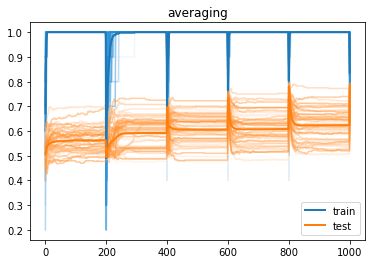

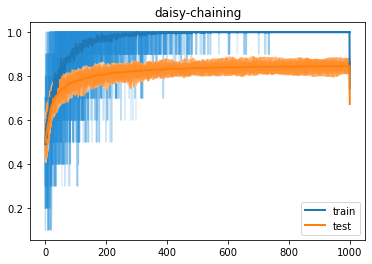

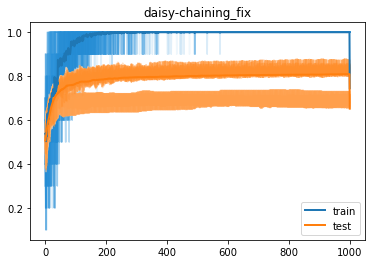

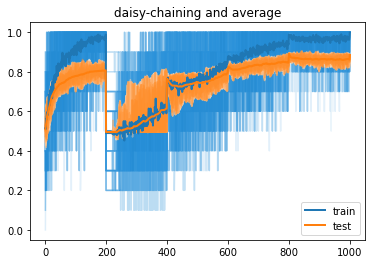

In [17]:
plotResults(trainACCs_avg, testACCs_avg, 'averaging')
plotResults(trainACCs_sdc, testACCs_sdc, 'daisy-chaining')
plotResults(trainACCs_sdcfix, testACCs_sdcfix, 'daisy-chaining_fix')
plotResults(trainACCs_sdcavg, testACCs_sdcavg, 'daisy-chaining and average')

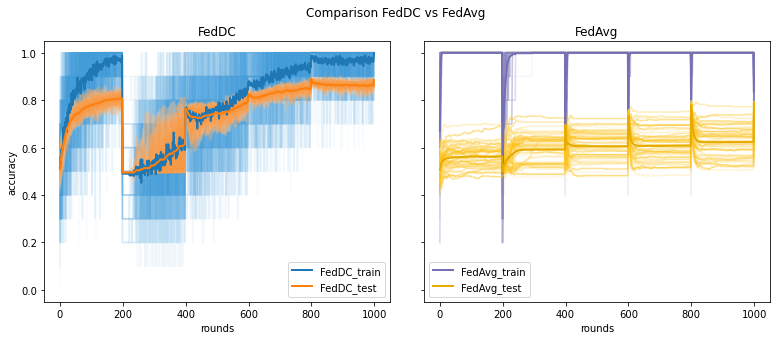

In [20]:
viridis = cm.get_cmap('viridis')
plasma =  cm.get_cmap('plasma')
cividis =  cm.get_cmap('cividis')
tab10 = cm.get_cmap('tab10')
tab20c = cm.get_cmap('tab20c')
Dark2 = cm.get_cmap('Dark2')

#colors = [tab10(0.0),tab10(0.1),tab20c(0.05),tab20c(0.3)]
colors = [tab10(0.0),tab10(0.1),Dark2(0.3),Dark2(0.7)]
plotComparison(trainACCs_sdcavg, testACCs_sdcavg, trainACCs_avg, testACCs_avg, "FedDC", "FedAvg", colors = colors, alphas = [0.1,0.5], filename = "comparisonFedDCvsFedAvg4.pdf")

In [23]:
print("Final test accuracies: FedDC:",np.mean(testACCs_sdcavg[-1])," FedAvg:",np.mean(testACCs_avg[-1]))

Final test accuracies: FedDC: 0.8850000000000001  FedAvg: 0.7900000000000003
